### Deepwalk

This tutorial discusses the Deepwalk algorithm. The algorithm is a method for finding node embeddings. 

The Deepwalk algorithm was presented in 
```
        Perozzi, B., Al-Rfou, R., & Skiena, S. (2014, August). Deepwalk: Online learning of social representations. In Proceedings of the 20th ACM SIGKDD international conference on Knowledge discovery and data mining (pp. 701-710).
```

The code for the Deepwalk portion of this Jupyter notebook tutorial is a modified version of the code from page 40 of _Hands-On Graph Neutral Networks Using Python_ by Maxime Labonne.

---


#### Node Embedding

Recall the definition of a node embedding: "A node embedding is a low-dimensional vector that has the property that two nodes that are similar to each other in the graph are close to each the vector space." (I've lost the source of this quote so please don't use it.)

We want to find a definition of node similarity that represences abstract ideas of _structural equivalence_ or _relational equivalence_ and represents the similarity as a low dimensional vector

The Deepwalk algorithm says that two nodes are similar if they are visited about the same number of times as each other on a random walk. The frequency with which a node is visited defines the embedding, and such embeddings are called _random-walk node embedding_. 

---

**Random Walks on the Karate Club Network**

We'll explore the basics of the Deepwalk algorithm on the Karate network. The club split into two groups, one led by an _Officer_ in the original club and the other led by a club member known as _Mr. Hi_.

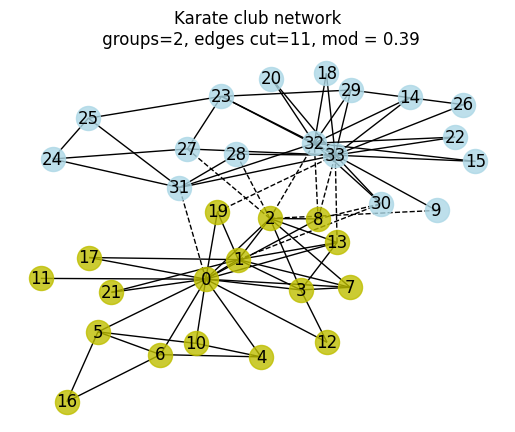

In [45]:
import networkx as nx
from typing import Hashable
from drawing_utilities import show_partitions
from drawing_utilities import show_partitions_with_scaled_nodesize
from drawing_utilities import show_node_probability
from drawing_utilities import show_graph

G: nx.Graph = nx.karate_club_graph()
partition: dict[str,list[Hashable]] = {'Mr. Hi': [], 'Officer': []}
for node in G.nodes():
    partition[G.nodes[node]['club']].append(node)
show_partitions(G, list(partition.values()), title = "Karate club network\n")


Show nodes with node size scaled to degree. Nodes with high degree are likely to be visited more on random walks.

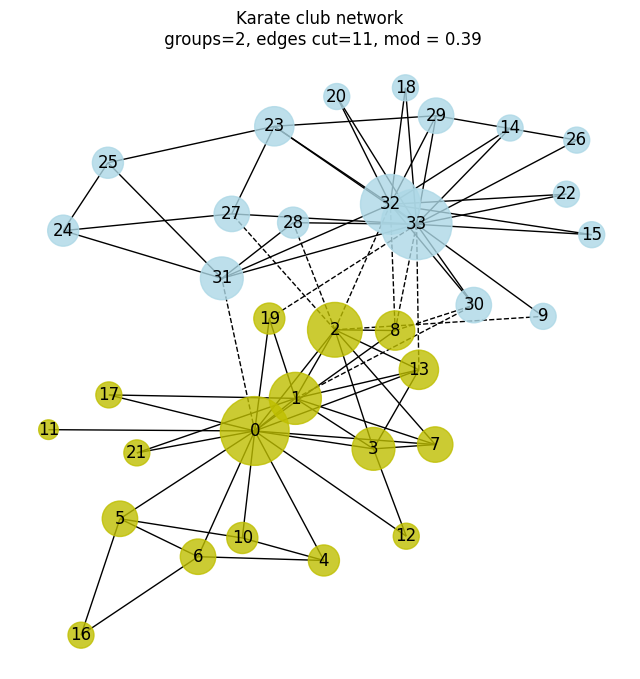

In [46]:
show_partitions_with_scaled_nodesize(G, list(partition.values()), title = "Karate club network\n")


---

**Unbiased Random Walks**

We'll define three functions:
- A function that captures an unbiased random walk. 
- A function that takes a starting node, a walk length, and a number of trials and returns a dictionary of {node: number of visits}
- A function that assigns a probability that a node was visited on a particular random walk given the following inputs 
  - dictionary of {node: number of visits} and
  - the number of trials 

Let's define those functions

In [47]:
import numpy as np
import random
random.seed(42)
def unbiased_random_walk(G: nx.Graph,
                         start: Hashable,
                         length: int
                         ) -> list[Hashable]:
    #function for performing uniformly random walk
    walk: list[Hashable] = [start] # starting node
    current_node: Hashable = start
    for _ in range(length):
        neighbors = [node for node in G.neighbors(current_node)]
        next_node = random.choice(neighbors)
        walk.append(next_node)
        current_node = next_node
    return walk

def count_node_visits(G: nx.Graph, 
                      starting_node: Hashable, 
                      walk_length: int, 
                      num_trials: int
                      ) -> dict[Hashable, int]:
    node_count_dict = dict.fromkeys(G.nodes,0)
    walks = []
    for _ in range(num_trials):
        walk = unbiased_random_walk(G,starting_node,walk_length)
        walks.append(walk)
    for walk in walks:
        for visited_node in walk:
            node_count_dict[visited_node] += 1
    return node_count_dict

def normalize(node_count_dict: dict[Hashable, int],
              num_trials: int
              ) -> list[float]:
    node_probabilities: list[float] = []
    for node in node_count_dict.keys():
        node_probabilities.append(min(1,node_count_dict[node]/num_trials))
    return node_probabilities

**Frequency of Node Visits**

Build some intuition by collecting a bunch of random walks that start at a particular node. Then plot the frequency with which various other nodes in the network were visited.

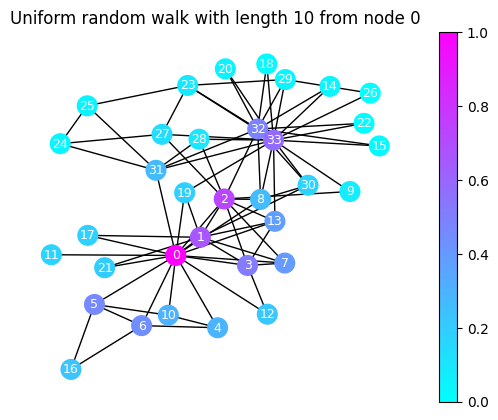

In [48]:
############
## CELL 1 ##
############
WALK_LENGTH = 10
NUM_TRIALS = 200
STARTING_NODE = 0

node_count_dict: dict = count_node_visits(G, STARTING_NODE, WALK_LENGTH, NUM_TRIALS)
node_probabilities = normalize(node_count_dict, NUM_TRIALS)

show_node_probability(G,
                      node_probabilities,
                      title=f"Uniform random walk with length {WALK_LENGTH} from node {STARTING_NODE}", 
                      show_scale=True)


Perform the following exercises:
 - shorten the path length and discuss what happens
 - increase the path length and discuss what happens
 - start from a node on periphery of the graph and discuss what happens
 - start with a high degree node and discuss what happens.

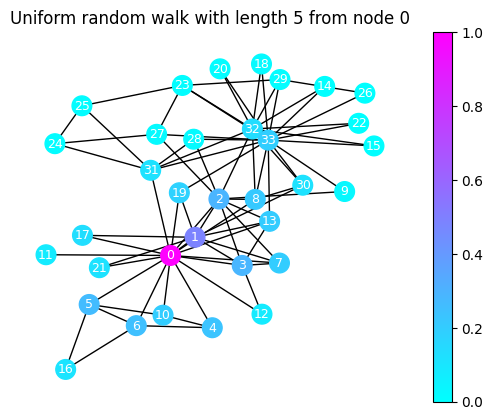

In [49]:
############
## Cell 2 ##
############

WALK_LENGTH = 5
NUM_TRIALS = 200
STARTING_NODE = 0

node_count_dict: dict = count_node_visits(G, STARTING_NODE, WALK_LENGTH, NUM_TRIALS)
node_probabilities = normalize(node_count_dict, NUM_TRIALS)

show_node_probability(G,
                      node_probabilities,
                      title=f"Uniform random walk with length {WALK_LENGTH} from node {STARTING_NODE}", 
                      show_scale=True)

---

#### Deepwalks Core Idea

The basic idea of the Deepwalk algrithm is to take a bunch of random walks and then find a way to use how often nodes appear on the same walk to represent node similarity. Deepwalk doesn't just count the number of times a node is visted, and instead uses an anology that involves words.  The analogy is this: _If you take a very large corpus of literatue and then start to look at how often words appear close to each other, you get a sense of how "similar" the words are to each other_.

**From Frequency to Co-Occurrence**

The random-walk analog for "two words are similar if they occur close to each other in common sentences" is "to nodes are similar if they occur close to each other on a lot of random walks."

Define a method that collects some random walks from a starting node of a particular length

In [50]:
def get_walks(G: nx.Graph, 
              starting_node: Hashable, 
              walk_length: int, 
              num_walks: Hashable
              ) -> list[Hashable]:
    walks: list[Hashable] = []
    for _ in range(num_walks):
        walk = unbiased_random_walk(G,starting_node,walk_length)
        walks.append([str(node) for node in walk])
    return walks

Let's peak at what a handful of these walks look like.

In [51]:
############
## CELL 2 ##
############

STARTING_NODE = 5
WALK_LENGTH = 3
NUM_WALKS = 5
walks = get_walks(G, STARTING_NODE, WALK_LENGTH, NUM_WALKS)
for walk in walks: 
    print(walk)

['5', '10', '4', '0']
['5', '6', '0', '19']
['5', '6', '5', '6']
['5', '16', '6', '5']
['5', '0', '13', '0']


**Collecting Random Walks into Training Data**

We do a set of these Deepwalks starting at each node in the graph, and collect all the walks into a "corpus" of walks. Folloiwng the example in chapter 3 of _Hands-On Graph Neural Networks Using Python_, Maxime Labonne.Let's do 100 random walks for each starting node, and limit the number of steps in each walk to 10. I'll print out the first two random walks that start at node 0.

In [52]:
WALK_LENGTH = 10
NUM_WALKS = 100

walks: list[Hashable] = []

for node in G.nodes():
    walks.extend(get_walks(G, node, WALK_LENGTH, NUM_WALKS))

# Look at some walks that begin at node 0 and at node 1    
node: int = 0
print(f"The first walk that begins at node {node} = \n  {walks[NUM_WALKS*node + 0]}")
print(f"The second walk that begins at node {node} = \n  {walks[node + 1]}")
node: int = 1
print(f"The first walk that begins at node {node} = \n  {walks[NUM_WALKS*node + 0]}")
print(f"The second walk that begins at node {node} = \n  {walks[NUM_WALKS*node + 1]}")


The first walk that begins at node 0 = 
  ['0', '2', '3', '1', '30', '1', '19', '0', '21', '1', '13']
The second walk that begins at node 0 = 
  ['0', '12', '0', '21', '0', '13', '1', '13', '33', '26', '29']
The first walk that begins at node 1 = 
  ['1', '7', '0', '13', '3', '0', '8', '33', '29', '26', '33']
The second walk that begins at node 1 = 
  ['1', '0', '17', '1', '19', '33', '27', '2', '0', '10', '0']


---

### Train model

Now that we have training data, we will train a model. See the accompanying slide deck. Also see [Word2Vec in Python](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html)

We don't have a lot of data (100 walks for each node), so don't try to make emedding dimenions that are too big. According to the things I've read and seen, 100 dimensions is pretty typical. That seems a little strange since there are only 34 nodes in the karate graph, but let's see where it leads us.  I'm going to set the seed so that each time I run the simulation I get the same results.


**Training Code**

Deepwalk uses an existing training model based on the well-known _Skipgram_ model for embedding words. Implementing the code from Maximme's book.

In [53]:
from gensim.models.word2vec import Word2Vec
embedding_dimension = 100 
## parameters from the book
model = Word2Vec(walks,
                 hs=1, #softmax = 0, hierarchical softmax = 1
                 sg=1, #skip-gram
                 vector_size=embedding_dimension,
                 window=WALK_LENGTH,
                 workers=2, negative = 10,
                 seed=0)
model.train(walks,
            total_examples=model.corpus_count,
            epochs=30, 
            report_delay=1)

(234970, 1122000)

We can now look at which nodes are similar to which other nodes.

In [54]:
target_node = 0
string_node = str(target_node)
print(f'Nodes that are most similar to node {target_node}:')
for similarity in model.wv.most_similar(positive=[string_node]):
    print(f' {similarity}')    

Nodes that are most similar to node 0:
 ('10', 0.7058500051498413)
 ('4', 0.6912975311279297)
 ('5', 0.6839209198951721)
 ('6', 0.6599871516227722)
 ('3', 0.6316488981246948)
 ('12', 0.6265043020248413)
 ('16', 0.6191328167915344)
 ('11', 0.5889228582382202)
 ('21', 0.5878862738609314)
 ('17', 0.5834786891937256)


Nodes 0 and 33 play similar roles in the karate club network, so let's check out how similar they are.

In [55]:
print(f"Similarity between node 0 and node 33: {model.wv.similarity('0','33')}")

Similarity between node 0 and node 33: 0.09513843059539795


That's low. Why? Because deep random walks like this emphasize structural equivalence rather than relational equivalence. Let's look at one of the nodes in the general neighborhood of node 0. 

In [56]:
print(f"Similarity between node 0 and node 16: {model.wv.similarity('0','16')}")

Similarity between node 0 and node 16: 0.6191328763961792


That's much higher. Why? Because node 0 and node 16 share a lot common neighbors. That suggests that we can probably cluster nodes into common neighborhoods.

---
---

Let's see what happens when we apply this to the pinwheel graph.

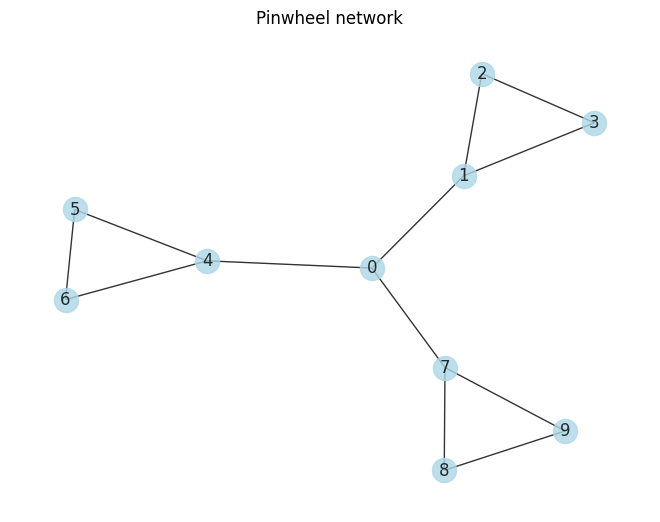

In [57]:
pinwheel_graph = nx.Graph()
pinwheel_graph.add_nodes_from([0,1,2,3,4,5,6,7,8,9])
pinwheel_graph.add_edges_from([(1,2),(1,3),(2,3),(4,5),(4,6),(5,6),(7,8),(7,9),(8,9),(1,0),(4,0),(7,0)])
show_graph(pinwheel_graph, title="Pinwheel network")

Collect walks

In [58]:
WALK_LENGTH = 8
NUM_WALKS = 80

walks: list[Hashable] = []

for node in pinwheel_graph.nodes():
    walks.extend(get_walks(pinwheel_graph, node, WALK_LENGTH, NUM_WALKS))

print("Walks that start at node 0:")
print("\t",walks[0])
print("\t",walks[1])
print("Walks that start at node 1:")
print("\t",walks[80])
print("\t",walks[81])

Walks that start at node 0:
	 ['0', '7', '0', '4', '5', '6', '4', '5', '6']
	 ['0', '4', '6', '4', '5', '4', '6', '4', '0']
Walks that start at node 1:
	 ['1', '2', '1', '3', '1', '0', '4', '5', '6']
	 ['1', '3', '1', '2', '3', '1', '2', '1', '2']


Define model. Note that this is a small graph, so we don't want the embedding dimension to be too big. If we try to make the embedding dimension too big, there won't be enough data to learn the matrix parameters, and we'll end up with garbage. Some key parameters are
 - hs 
    - when = 0 means we use the softmax like discussed in the slides
    - when = 1 means we use the hierarchical softmax method defined in the original Deepwalk paper to speed up learning
 - sg = 1 means that we use the skipgram model like we defined it in the slides
 - vector_size = the size of the matrix we are trying to learn in the hidden layer. This specifies how many dimensions our embedding ${\mathbb R}^d$ has.
 - window. Don't confuse the length of the walk used to create the set of random walks with the length of the window used to create the co-occurrence account. In this example, the length of the window equals the length of the walk
 - the other parameters require more deep understanding for how the neural network training occurs, so we won't discuss this in class.

In [59]:
## Define the model
from gensim.models.word2vec import Word2Vec
embedding_dimension = 8 
model = Word2Vec(walks,
                 hs=0, #softmax = 0, hierarchical softmax = 1
                 sg=1, #skip-gram
                 vector_size=embedding_dimension,
                 window=WALK_LENGTH,
                 workers=2, negative = 10,
                 seed=0)

Train the model. 

In [60]:
model.train(walks,
            total_examples=model.corpus_count,
            epochs=30, 
            report_delay=1)

(23720, 216000)

Print out the nodes most similar to node 4 to help us build intuition.

In [61]:
target_node = 4
string_node = str(target_node)
print(f'Nodes that are most similar to node {target_node}:')
for similarity in model.wv.most_similar(positive=[string_node]):
    print(f' {similarity}')   

Nodes that are most similar to node 4:
 ('5', 0.9425143003463745)
 ('6', 0.9422515630722046)
 ('0', 0.7012492418289185)
 ('7', 0.45163848996162415)
 ('1', 0.4076520800590515)
 ('3', 0.3605906665325165)
 ('9', 0.35979634523391724)
 ('8', 0.3541373312473297)
 ('2', 0.31498029828071594)


Let's look at the matrix that was learned. The raw values probably don't mean a lot to you, but notice that the dimensions of the matrix. It has 10 columns, one for each node in the pinwheel network, and 8 rows, one for each of the dimensions we specified in our model.

In [62]:
nodes_wv = np.array([model.wv.get_vector(str(i)) for i in range(len(model.wv))])
print(np.transpose(np.round(nodes_wv,2)))

[[-0.43  0.02 -0.45 -0.62 -0.51 -0.29 -0.49  0.14  0.03 -0.28]
 [ 0.62  1.02  1.32  1.44  0.89  0.84  1.16 -0.08 -0.17 -0.11]
 [ 0.17  0.23  0.22 -0.22  0.64  0.85  1.01  0.01  0.1  -0.28]
 [-0.05  0.56 -0.09  0.26  1.01  0.93  0.6   0.68  0.61  0.23]
 [-0.18 -0.51 -0.41 -0.68  0.09  0.57  0.23 -0.95 -1.39 -1.39]
 [ 0.66 -0.35 -0.42 -0.49  0.64  1.06  1.11  0.89  1.13  1.31]
 [ 0.5  -0.15 -0.1  -0.03  0.94  1.01  0.96  0.37  0.18  0.62]
 [-0.73 -1.28 -1.7  -1.41 -0.22 -0.53 -0.22 -1.02 -1.14 -1.05]]


Each node has it's own vector because we were computing

$$ f : V \rightarrow {\mathbb R}^d $$

We chose $d=10$. Let's inspect the row for a few of the nodes. All we are doing here is pulling out the column associated with particular nodes.

In [63]:
target_node = 2
print("The embedding for node",target_node)
print(f"  {np.round(model.wv.get_vector(str(target_node)),2)}")
target_node = 5
print("The embedding for node",target_node)
print(f"  {np.round(model.wv.get_vector(str(target_node)),2)}")


The embedding for node 2
  [-0.45  1.32  0.22 -0.09 -0.41 -0.42 -0.1  -1.7 ]
The embedding for node 5
  [-0.29  0.84  0.85  0.93  0.57  1.06  1.01 -0.53]


---

### Using the embedding

Let's use a well-known algorithm for taking the $8\times 10$ embedding matrix and turning it into 2D vector. Essentially, we want to compress all the information from the embedding matrix into the best two dimensions so that we can visualize the results. The algorithm we'll use is called TSNE. You can use it without understanding it well -- that's what I'm doing this semester.

We did something similar with the spectrum of the Laplacian matrix of the adjacency matrix, but we did this by hand by just choosing our favorite two eigenvectors. TSNE says "You might now know which parts of the matrix are most important, so I'll help you find them."

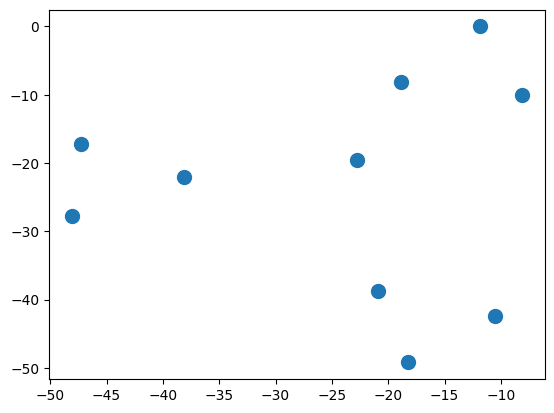

In [64]:
from sklearn.manifold import TSNE 
import matplotlib.pyplot as plt
tsne = TSNE(n_components=2,
            learning_rate='auto',
            init='pca',
            random_state=0,
            perplexity=5.0).fit_transform(nodes_wv)
plt.scatter(tsne[:, 0], tsne[:, 1], s=100)

Let's cluster like we did with the spectrum of $L$ and the spectrum of $A$.

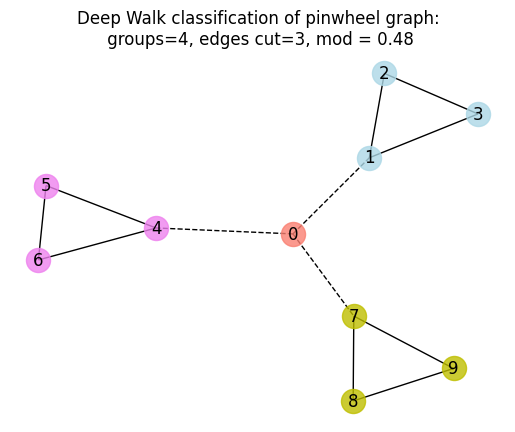

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(
    init="random",
    n_clusters=4,
    n_init=10,
    random_state=1234
    )
kmeans.fit(tsne)

# See how things clustered
labels = kmeans.labels_
partition: dict[int, list[Hashable]] = {key:[] for key in sorted(labels)}
for node in pinwheel_graph:
    partition[labels[node]].append(node)
show_partitions(pinwheel_graph, partition=list(partition.values()), title="Deepwalk classification of pinwheel graph:\n")


---